<a href="https://colab.research.google.com/github/VictoorV/Transformer_Pre_In/blob/main/Transformer_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer

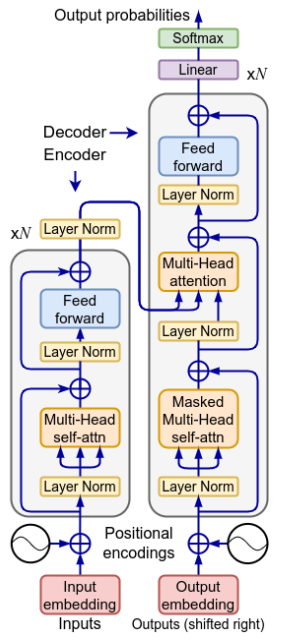

## Model

In [259]:
import copy
import numpy as np
import math
import torch

######################################################################################################## Avoir plusieurs modudes avec des références différentes
def clones(module, n):
    return torch.nn.ModuleList([copy.deepcopy(module) for _ in range(n)])

######################################################################################################## Scaled Dot Product Attention
def ScaledDotProductAttention(Q, K, V, mask = None):
  """
  Q : Query head ; shape : batch x n_head x n_token x d_head
  K : Key head ; shape : batch x n_head x n_token x d_head
  V : Value head ; shape : batch x n_head x n_token x d_head
  """

  d_head = Q.size(-1)
  scores = torch.matmul(Q, K.transpose(-2,-1)) / math.sqrt(d_head) # shape : batch * n_head * n_token * n_token
  if mask is not None:
    scores.masked_fill_(mask==0, -1e9)

  weights = scores.softmax(-1)
  return torch.matmul(weights, V), weights

######################################################################################################## Multi-Head Attention
class Multi_Head_Attention(torch.nn.Module):
  def __init__(self, n_head, d_model, dropout=0.1):
    super(Multi_Head_Attention, self).__init__()
    assert d_model % n_head == 0
    self.n_head = n_head
    self.d_head = d_model // n_head
    self.layers = clones(torch.nn.Linear(d_model, d_model), 4)
    self.weights = None
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, Q, K, V, mask=None):
    """
    Q : Query embedding ; shape : batch x n_token x d_model
    K : Key embedding ; shape : batch x n_token x d_model
    V : Value embedding ; shape : batch x n_token x d_model
    """
    if mask is not None:
      mask.unsqueeze(1)

    batch_size = Q.size(0)
    Q, K, V = [l(x).view(batch_size, -1, self.n_head, self.d_head).transpose(1,2) for l, x in zip(self.layers, (Q, K, V))] # batch x n_head x n_token x d_head
    x, self.weights = ScaledDotProductAttention(Q, K, V) # batch x n_head x n_token x d_head
    x = x.transpose(1,2).contiguous().view(batch_size, -1, self.n_head * self.d_head) # batch x n_token x d_model
    return self.layers[-1](self.dropout(x))

######################################################################################################## Double FFN
class FFN(torch.nn.Module):
  def __init__(self, d_model, d_ffn, dropout=0.1):
    super(FFN, self).__init__()
    self.layer1 = torch.nn.Linear(d_model, d_ffn)
    self.layer2 = torch.nn.Linear(d_ffn, d_model)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, x):
    return self.layer2(self.dropout(torch.nn.functional.silu(self.layer1(x))))

######################################################################################################## Addition et normalisation pre-in
class PreNormResidual(torch.nn.Module):
  def __init__(self, d_model, dropout=0.1):
    super(PreNormResidual, self).__init__()
    self.norm = torch.nn.LayerNorm(d_model)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, x, sublayer):
    return x + self.dropout(sublayer(self.norm(x)))

######################################################################################################## Encoder block
class EncoderBlock(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn):
    super(EncoderBlock, self).__init__()
    self.MHA = Multi_Head_Attention(n_head, d_model)
    self.Norm_And_Add = clones(PreNormResidual(d_model), 2)
    self.FFN = FFN(d_model, d_ffn)

  def forward(self, x, source_mask):
    """
    x : Input ; shape : batch x n_token x d_model
    source_mask : Mask of source sentence (padding tokens are masked) ; shape : batch x n_token x n_token
    """
    x = self.Norm_And_Add[0](x, lambda x: self.MHA(x, x, x, mask=source_mask))
    x = self.Norm_And_Add[1](x, self.FFN)
    return x

######################################################################################################## Encoder
class Encoder(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn, N):
    super(Encoder, self).__init__()
    self.layers = clones(EncoderBlock(n_head, d_model, d_ffn), N)

  def forward(self, x, source_mask):
    for layer in self.layers:
      x = layer(x, source_mask)
    return x

######################################################################################################## Decoder block
class DecoderBlock(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn):
    super(DecoderBlock, self).__init__()
    self.MHA_Masked = Multi_Head_Attention(n_head, d_model)
    self.MHA_Encoder = Multi_Head_Attention(n_head, d_model)
    self.Norm_And_Add = clones(PreNormResidual(d_model), 3)
    self.FFN = FFN(d_model, d_ffn)

  def forward(self, x, encoder_output, source_mask, target_mask):
    """
    x : Output ; shape : batch x n_token x d_model
    encoder_output : Encoder final states ; shape : batch x n_token x d_model
    source_mask : Mask of source sentence (padding tokens are masked) ; shape : batch x n_token x n_token
    target_mask : Mask of target sentence (future and padding tokens are masked) ; shape : batch x n_token x n_token
    """
    x = self.Norm_And_Add[0](x, lambda x: self.MHA_Masked(x, x, x, mask=target_mask))
    x = self.Norm_And_Add[1](x, lambda x: self.MHA_Encoder(x, encoder_output, encoder_output, mask=source_mask))
    x = self.Norm_And_Add[2](x, self.FFN)
    return x

######################################################################################################## Decoder
class Decoder(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn, N):
    super(Decoder, self).__init__()
    self.layers = clones(DecoderBlock(n_head, d_model, d_ffn), N)

  def forward(self, x, encoder_output, source_mask, target_mask):
    for layer in self.layers:
      x = layer(x, encoder_output, source_mask, target_mask)
    return x
######################################################################################################## Encoder + Decoder
class EncoderDecoder(torch.nn.Module):
  def __init__(self, n_head, d_model, d_ffn, N):
    super(EncoderDecoder, self).__init__()
    self.encoder = Encoder(n_head, d_model, d_ffn, N)
    self.decoder = Decoder(n_head, d_model, d_ffn, N)
    self.norm = torch.nn.LayerNorm(d_model)

  def forward(self, source, target, source_mask, target_mask):
    encoder_output = self.norm(self.encoder(source, source_mask))
    return self.decoder(target, encoder_output, source_mask, target_mask)

######################################################################################################## Embedding
class Embeddings(torch.nn.Module):
  def __init__(self, d_model, voc_size):
    super(Embeddings, self).__init__()
    self.embedding = torch.nn.Embedding(voc_size, d_model)
    self.d_model = d_model

  def forward(self, x):
    """
    x : Input (int) ; shape : batch * n_token
    """
    return self.embedding(x) * math.sqrt(self.d_model)

######################################################################################################## Positional encoding
class PositionalEncoding(torch.nn.Module):
  def __init__(self, d_model, max_token=5000):
    super(PositionalEncoding, self).__init__()
    pe = torch.zeros(max_token, d_model)
    position = torch.arange(0, max_token).reshape(max_token, 1)
    div = 10000**(-torch.arange(0, d_model, 2)/d_model)
    pe[:,0::2] = torch.sin(position * div)
    pe[:,1::2] = torch.cos(position * div)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe) # Pas besoin de déplacer sur le gpu et les gradients ne sont pas calculés sur pe

  def forward(self, x):
    """
    x : Embedding ; shape : batch * n_token * d_model
    """
    return x + self.pe[:, :x.size(1)]

######################################################################################################## Build Transformer
class Transformer(torch.nn.Module):
  def __init__(self, source_vocab_size, target_vocab_size, n_head, d_model, d_ffn, N):
    super(Transformer, self).__init__()
    self.source_embedding = Embeddings(d_model, source_vocab_size)
    self.target_embedding = Embeddings(d_model, target_vocab_size)
    self.PE = PositionalEncoding(d_model)
    self.encoder_decoder = EncoderDecoder(n_head, d_model, d_ffn, N)
    self.output_layer = torch.nn.Linear(d_model, target_vocab_size)
    for p in self.parameters():
            if p.dim() > 1:
                torch.nn.init.xavier_uniform_(p)

  def forward(self, source, target, source_mask, target_mask):
    """
    source : Input (int) ; shape : batch * n_token
    target : Output (int) ; shape : batch * n_token
    """
    source = self.PE(self.source_embedding(source))
    target = self.PE(self.target_embedding(target))
    output = self.output_layer(self.encoder_decoder(source, target, source_mask, target_mask))
    return output.softmax(-1)

In [250]:
input_seq = [
    ["salut", "comment", "ca", "va", "?"],
    ["je", "veux", "beaucoup", "de", "fruits", "rouges", "."],
    ["j'", "aimerais", "manger", "des", "fruits", "."],
    ["regarde", "ces", "petits", "oiseaux", "faire", "du", "vent", "."]
             ]

output_seq = [
    ["<START>", "hi", "how", "are", "you", "?", "<END>"],
    ["<START>", "i", "want", "a", "lot", "of", "red", "fruits", ".", "<END>"],
    ["<START>", "i", "would", "like", "to", "eat", "fruits", ".", "<END>"],
    ["<START>", "look", "at", "these", "little", "birds", "blowing", "the", "wind", ".", "<END>"]
]

def get_vocabulary(sequences):
  vocabulary = {}
  vocabulary["<PAD>"] = 0; vocabulary["<UNK>"] = 1; vocabulary["<START>"] = 2; vocabulary["<END>"] = 3
  for sequence in sequences:
    for token in sequence:
      if token not in vocabulary:
        vocabulary[token] = len(vocabulary)
  return vocabulary

input_voc = get_vocabulary(input_seq)
output_voc = get_vocabulary(output_seq)

print(input_voc)
print(output_voc)

def seq_to_int(sequences, voc, max_length=None):
  sequences_copy = copy.deepcopy(sequences)
  for sequence in sequences_copy:
    if max_length is not None:
      while len(sequence) < max_length:
        sequence.append("<PAD>")
    for i, word in enumerate(sequence):
      if word in voc:
        sequence[i] = voc[word]
      else:
        sequence[i] = voc["<UNK>"]
  return(sequences_copy)

max_input_len = max(len(seq) for seq in input_seq)
max_output_len = max(len(seq) for seq in output_seq)

input_to_int = seq_to_int(input_seq, input_voc, max_input_len)
output_to_int = seq_to_int(output_seq, output_voc, max_output_len)

tensor_input_to_int = torch.tensor(input_to_int).int()
tensor_output_to_int = torch.tensor(output_to_int).int()

print("source tenseur padded:\n", tensor_input_to_int)
print("target tenseur padded:\n,", tensor_output_to_int)

def create_source_mask(source_tensor, voc):
  mask = source_tensor != voc["<PAD>"]
  mask = mask.unsqueeze(1) * torch.ones(source_tensor.size(-1)).unsqueeze(1)
  return mask.bool()

source_mask = create_source_mask(tensor_input_to_int, input_voc)
print("source_mask:\n", source_mask)

def create_target_mask(target_tensor, voc):
  mask = target_tensor != voc["<PAD>"]
  mask = mask.unsqueeze(1) * torch.ones(target_tensor.size(-1)).unsqueeze(1)
  mask = mask * torch.tril(torch.ones(mask.size(1), mask.size(1))).unsqueeze(0)
  return mask.bool()

target_mask = create_target_mask(tensor_output_to_int, output_voc)
print("target_mask:\n", target_mask)

{'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3, 'salut': 4, 'comment': 5, 'ca': 6, 'va': 7, '?': 8, 'je': 9, 'veux': 10, 'beaucoup': 11, 'de': 12, 'fruits': 13, 'rouges': 14, '.': 15, "j'": 16, 'aimerais': 17, 'manger': 18, 'des': 19, 'regarde': 20, 'ces': 21, 'petits': 22, 'oiseaux': 23, 'faire': 24, 'du': 25, 'vent': 26}
{'<PAD>': 0, '<UNK>': 1, '<START>': 2, '<END>': 3, 'hi': 4, 'how': 5, 'are': 6, 'you': 7, '?': 8, 'i': 9, 'want': 10, 'a': 11, 'lot': 12, 'of': 13, 'red': 14, 'fruits': 15, '.': 16, 'would': 17, 'like': 18, 'to': 19, 'eat': 20, 'look': 21, 'at': 22, 'these': 23, 'little': 24, 'birds': 25, 'blowing': 26, 'the': 27, 'wind': 28}
source tenseur padded:
 tensor([[ 4,  5,  6,  7,  8,  0,  0,  0],
        [ 9, 10, 11, 12, 13, 14, 15,  0],
        [16, 17, 18, 19, 13, 15,  0,  0],
        [20, 21, 22, 23, 24, 25, 26, 15]], dtype=torch.int32)
target tenseur padded:
, tensor([[ 2,  4,  5,  6,  7,  8,  3,  0,  0,  0,  0],
        [ 2,  9, 10, 11, 12, 13, 14, 15, 16,  3,  0],

In [258]:
len(output_voc)

29

In [260]:
n_head = 8
d_model = 512
d_ffn = 2048
N = 6
model = Transformer(len(input_voc), len(output_voc), n_head, d_model, d_ffn, N)

In [263]:
model(tensor_input_to_int, tensor_output_to_int, source_mask, target_mask).shape

torch.Size([4, 11, 29])